# Calibration de modèles GARCH par des méthodes d'apprentissage
---

Le problème auquel nous nous attaquons est le suivant : nous disposons d'un signal qui suit un modèle $GARCH(1,1)$ et on essaye de déterminer les coefficients $\alpha_0, \alpha_1$ et $\beta_1$ qui le caractérisent.

Pour cela, on crée un réseau de neurones qui estimera les valeurs des coefficients du modèle à partir de différentes caractéristiques du signal tels que ses moments et ses autocovariances.

S'inspirant de l'article https://arxiv.org/pdf/2201.03286.pdf, nous utilisons une méthode d'entrainement du réseau de neurones plus efficace en temps de calcul. Au lieu de simuler complètement des signaux, nous générons aléatoirement des coefficients $(\alpha_0, \alpha_1, \beta_1)$ et nous calculons les moments théoriques d'un signal $GARCH$ ayant de tels coefficients. Ensuite, nous entrainons le réseau à retrouver a posteriori les coefficients $\alpha_1$ et $\beta_1$.

Ce notebook se divise en trois parties :

I - La partie théorique qui établie les premières formules donnant les moments\
II - La partie entrainement qui met en place le réseau de neurones et l'entraine\
III - La partie estimation qui génère des signaux $GARCH$ et essaye de déterminer les coefficients correspondants

---
### I - Parties théoriques
---

On a :
$$ \sigma_t^2 = \alpha_0 + \alpha_1  x_{t-1}^2 + \beta_1 \sigma_{t-1}^2$$
avec $x_t = \sigma_t Z_t$

**Moment d'ordre 2** 


On calcule le moment d'ordre 2 :

$$ \Gamma_2 = V[x_t] = E[x_t^2] - E[x_t]^2 = E[x_t^2] = E[\sigma_t^2 Z_t^2] = E[\sigma_t^2] E[Z_t^2] = E[\sigma_t^2] = \alpha_0 + \alpha_1 E[x_{t-1}^2] + \beta_1 E[\sigma_{t-1}^2] =  \alpha_0 + \alpha_1 E[x_{t-1}^2] + \beta_1 E[\sigma_t^2]$$

\begin{align*}
\Gamma_2 &= V[x_t] \\
 &= V[x_t]\\
 &= E[x_t^2] - E[x_t]^2\\
 &= E[x_t^2]\\
 &= E[\sigma_t^2 Z_t^2]\\
 &= E[\sigma_t^2] E[Z_t^2]\\
 &= E[\sigma_t^2]\\
 &= \alpha_0 + \alpha_1 E[x_{t-1}^2] + \beta_1 E[\sigma_{t-1}^2]\\
 &= \alpha_0 + \alpha_1 E[\sigma_{t-1}^2] + \beta_1 E[\sigma_t^2]\\
 &= \alpha_0 + \alpha_1 E[\sigma_{t}^2] + \beta_1 E[\sigma_t^2]\\
 &= \alpha_0 + \alpha_1 \Gamma_2 + \beta_1 \Gamma_2\\
\end{align*}\\

On a donc $ \Gamma_2 = \alpha_0 + \alpha_1 \Gamma_2 + \beta_1 \Gamma_2 $ donc $\Gamma_2 = \dfrac{\alpha_0}{1 - \alpha_1 - \beta_1 }$



**Moment d'ordre 4**

On calcule le moment d'ordre 4 :
$$
\begin{align*}
E[\sigma_t^4] &= E[(\alpha_0 + \alpha_1  x_{t-1}^2 + \beta_1 \sigma_{t-1}^2)^2]\\

&= \alpha_0^2 + \alpha_1^2E[x_{t-1}^4] + \beta_1^2 E[\sigma_{t-1}^4] + 2 \alpha_0 \alpha_1 E[x_{t-1}^2] + 2 \alpha_0 \beta_1 E[\sigma_{t-1}^2] + 2 \alpha_1 \beta_1 E[x_{t-1}^2\sigma_{t-1}^2]\\

&= \alpha_0^2 + \alpha_1^2E[\sigma_{t-1}^4]E[Z_{t-1}^4] + \beta_1^2 E[\sigma_{t-1}^4] + 2 \alpha_0 \alpha_1 E[\sigma_{t-1}^2]E[Z_{t-1}^2] + 2 \alpha_0 \beta_1 E[\sigma_{t-1}^2] + 2 \alpha_1 \beta_1 E[\sigma_{t-1}^4]E[Z_{t-1}^2] \\

&= \alpha_0^2 + \alpha_1^2E[\sigma_{t}^4]E[Z_{t}^4] + \beta_1^2 E[\sigma_{t}^4] + 2 \alpha_0 \alpha_1 E[\sigma_{t}^2]E[Z_t^2] + 2 \alpha_0 \beta_1 E[\sigma_{t}^2] + 2 \alpha_1 \beta_1 E[\sigma_{t}^4]E[Z_{t}^2] \\

&= \alpha_0^2 + 3\alpha_1^2E[\sigma_{t}^4] + \beta_1^2 E[\sigma_{t}^4] + 2 \alpha_0 \alpha_1 E[\sigma_{t}^2] + 2 \alpha_0 \beta_1 E[\sigma_{t}^2] + 2 \alpha_1 \beta_1 E[\sigma_{t}^4]
\end{align*}
$$

On obtient donc 
$$  (1- 3\alpha_1^2 - 2 \alpha_1 \beta_1 - \beta_1^2)E[\sigma_t^4] = \alpha_0^2 + 2( \alpha_0 \alpha_1  +  \alpha_0 \beta_1) E[\sigma_{t}^2]$$

Ce qui donne :

$$
\begin{align*}
\dfrac{E[x_t^4]}{E[x_t^2]^2} &= 3 \dfrac{E[\sigma_t^4]}{E[\sigma_t^2]^2}\\
&= 3\dfrac{\alpha_0^2 + 2( \alpha_0 \alpha_1  +  \alpha_0 \beta_1) E[\sigma_{t}^2]}{(1- 3\alpha_1^2 - 2 \alpha_1 \beta_1 - \beta_1^2)E[\sigma_t^2]^2}\\
&= 3\dfrac{(1-\alpha_1 - \beta_1)^2 + 2(\alpha_1  + \beta_1)(1-\alpha_1 - \beta_1) }{1- 3\alpha_1^2 - 2 \alpha_1 \beta_1 - \beta_1^2}\\
&= 3\dfrac{(1-\alpha_1 - \beta_1)(1+\alpha_1 + \beta_1) }{1- 3\alpha_1^2 - 2 \alpha_1 \beta_1 - \beta_1^2}\\
&= 3\dfrac{1-\alpha_1^2 -2 \alpha_1 \beta_1- \beta_1^2 }{1- 3\alpha_1^2 - 2 \alpha_1 \beta_1 - \beta_1^2}\\
&= 3 + \dfrac{6\alpha_1^2 }{1- 3\alpha_1^2 - 2 \alpha_1 \beta_1 - \beta_1^2}\\
\end{align*}


---
### II - Parties informatiques
---

**I - Paramètres**

Dans un premier temps, on conçoit un réseau de neurones qui à partir de différentes caractéristiques du signal (moments et autocovariances) arrivent à déterminer les coefficients du modèle.


In [57]:
""" Gestion des modules et des imports """

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import statsmodels
import scipy

from module.statistics import *
from module.signal import *
from module.trainingdata import *
from module.affichage import *
from module.neuralNetwork import *

from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
""" Paramètres généraux du notebook """

 # Paramètres du réseaux de neurones


nbrNodes = 256 # Nombre de neurones par couche
nbrMoments = 2 # Nombre de moments qui interviennent dans le système
nbrAutoCov = 1 # Nombre d'auto-covariances qui interviennent dans le système
nbrAutresParametres = 0 # Nombre d'autres paramètres qui interviennent dans le système

learningRate = 0.0001 # Taux d'apprentissage


# Paramètres de l'entrainement

nbrBoucle = 3000 # Nombre de boucles d'apprentissage
bachSize = 1000 # Taille des bachs d'apprentissage
frequenceResetBach = 10 # Fréquence de reset des bachs d'apprentissage
lossStop = 0.0001 # Valeur de loss à partir de laquelle on arrête l'apprentissage
frequenceAffichage = int(nbrBoucle/6) # Fréquence d'affichage des résultats

**II - Initialisation et entrainement**

Pour entrainer le réseau de neurones, nous utilisons une méthode détournée. 

Nous commençons par générer des coefficients $(\alpha_0,\alpha_1,\beta_1)$ alétaoires. Ensuite, nous déé

In [59]:
""" Création et paramétrage du réseau de neurones """

# Instanciation du réseau
net = NeuralNetwork(nbrAutoCov=nbrAutoCov, nbrMoments=nbrMoments, nbrNodes=nbrNodes, nbrAutresParametres=nbrAutresParametres)

# Définition de la fonction de perte et de l'optimiseur

# On crée une fonction de perte personnalisée
def customLoss(output, target):
    out = output.detach().numpy()
    tar = target.detach().numpy()
    return torch.mean((output - target)**2) + 0 * torch.mean((output - target)**4)

criterion = customLoss

# Optimiseur (Adam)
optimizer = optim.Adam(net.parameters(), lr=learningRate)

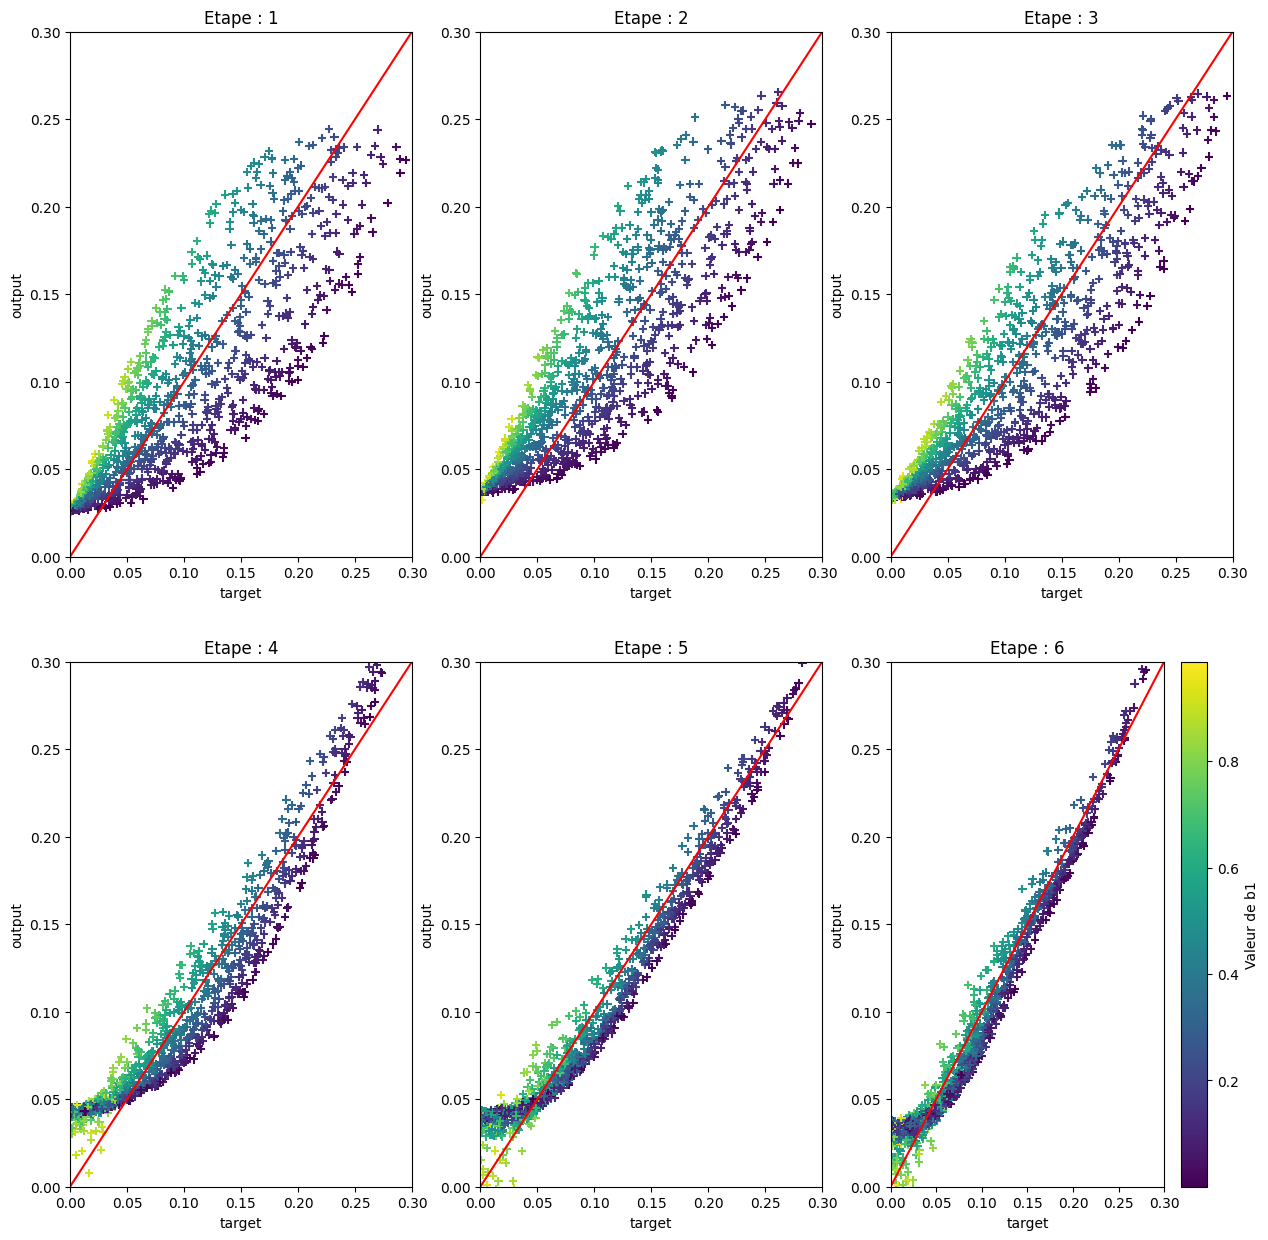

In [60]:
""" Boucle d'entrainement """

error = [] # Liste qui contiendra les erreurs commises par le réseau à chaque époque

inputs_tensor, targets_tensor = generate_data_theo(bachSize, nbrMoments=nbrMoments, nbrAutoCov=nbrAutoCov)

i = 0
fig, ax = plt.subplots(2,3,figsize=(15,15))

for epoch in range(nbrBoucle):

    # Reset des bachs d'apprentissage à chaque frequenceResetBach
    if epoch % frequenceResetBach == 0:
        inputs_tensor, targets_tensor = generate_data_theo(bachSize, nbrMoments=nbrMoments, nbrAutoCov=nbrAutoCov)
    
    # Réinitialiser les gradients
    optimizer.zero_grad()

    # Passage avant dans le réseau
    outputs = net(inputs_tensor)

    # Calcul de la perte
    loss = criterion(outputs, targets_tensor)
    
    # Calcul des gradients et mise à jour des poids
    loss.backward()
    optimizer.step()
    error.append(loss.item())

    # Arrêt de l'entrainement si la perte est trop faible
    if loss.item() < lossStop:
        print("\n Loss is too low, stopping")
        break

    # Affichage de la barre progression
    percent = (epoch+1) / nbrBoucle
    bar = "█" * int(30*percent) + " " * (30 - int(30*percent))
    progressBar = f"\r Progress : |{bar}| - {100*percent:.2f}% - Nombre d'époques : {epoch+1} - Erreur : {100*loss.item():.4f}"
    print(130*" ", end="\r")
    print(progressBar, end="\r")


    # Affichage des résultats
    if epoch % frequenceAffichage == frequenceAffichage-1:
        plots_results_a1(net, ax = ax, i=i, nbrMoments=nbrMoments, nbrAutoCov=nbrAutoCov)
        i+=1
plt.colorbar(ax[1,2].get_children()[0], ax=ax[1,2], label="Valeur de b1")
plt.show()


II - Simulation à partir de signaux générés

In [61]:
""" Paramètres de la simulation """

num_inputs = 100
num_samples = 100
timeSample = 200

a0 = 0.0001
a1 = 0.2
b1 = 0.4

[0.00025000000000000006, 3.428571428571429, 24.880952380952376, 0.3257142857142858, 0.11725714285714292, 0.04221257142857146]


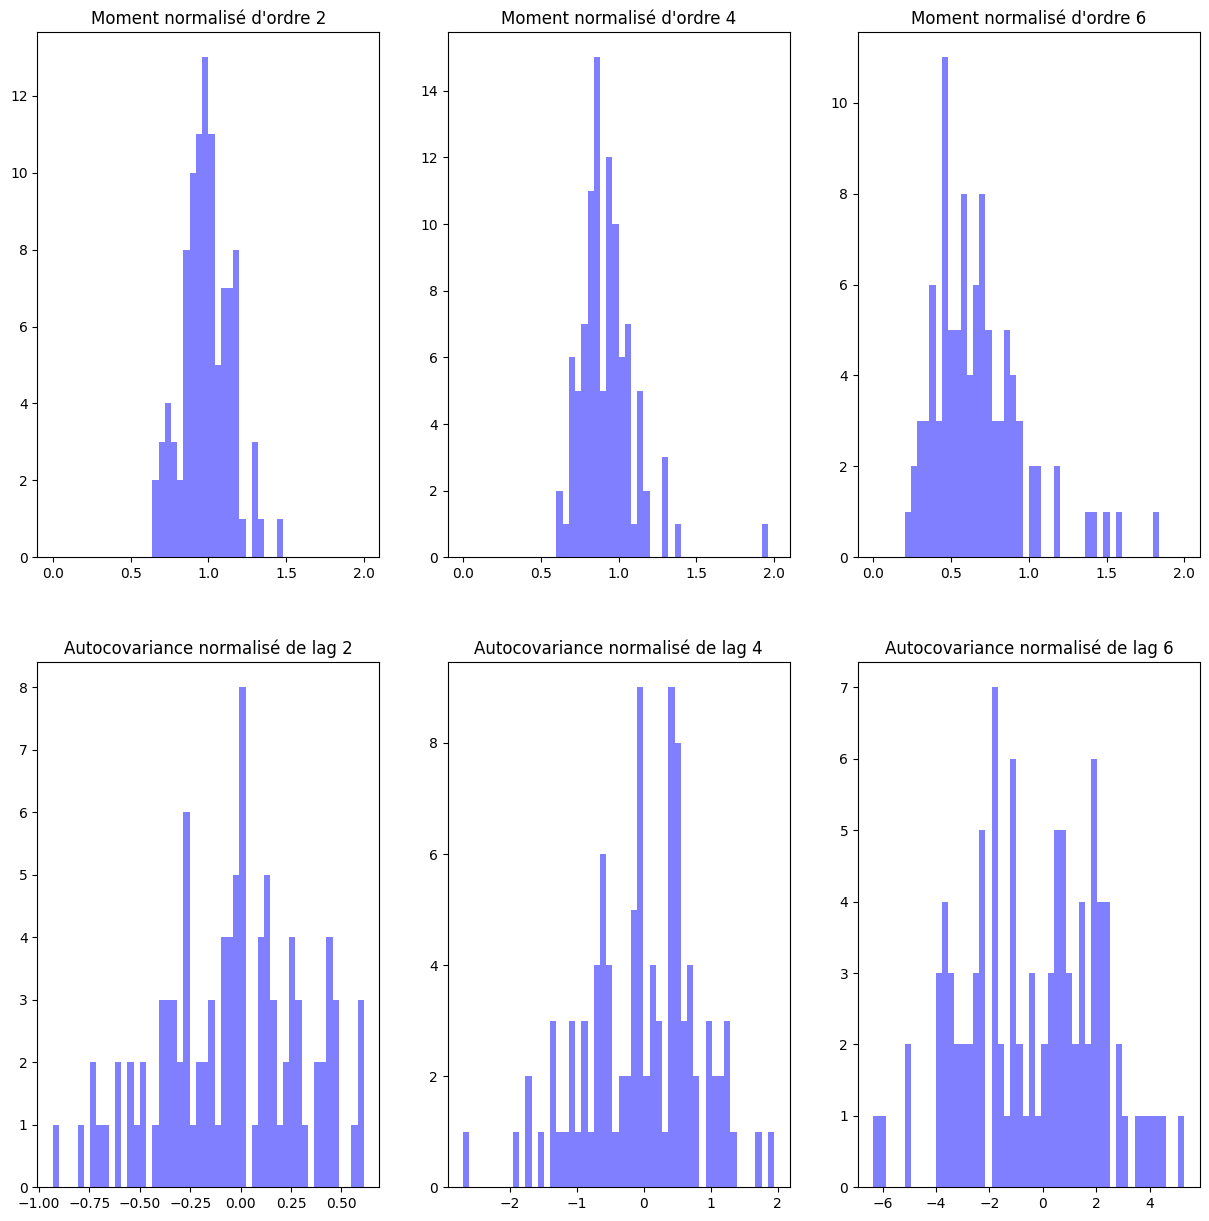

In [62]:
""" Comparaison des moments théoriques et empiriques """""

y = moments(a0,a1,b1, 3)
for i in range(3):
    y.append(autocovariance(a0,a1,b1,2*i+2))

inputs_tensor, targets_tensor = generate_data(num_inputs, num_samples, timeSample, nbrAutoCov=3, nbrMoments=3)


fig, ax = plt.subplots(2, 3, figsize = (15,15))

for i in range(3):
    ax[i//3][i%3].hist(inputs_tensor[:,i]/y[i], bins = 50, label = "Empirique", alpha = 0.5, color = "blue", range = (0,2))
    #ax[i//3][i%3].axvspan(0.9, 1.1, color='red', alpha=0.1)

    
for i in range(3,6):
    ax[i//3][i%3].hist(inputs_tensor[:,i]/y[i], bins = 50, label = "Empirique", alpha = 0.5, color = "blue")
    #ax[i//3][i%3].axvspan(0.9, 1.1, color='red', alpha=0.1)

print(y)
ax[0][0].set_title("Moment normalisé d'ordre 2")
ax[0][1].set_title("Moment normalisé d'ordre 4")
ax[0][2].set_title("Moment normalisé d'ordre 6")
ax[1][0].set_title("Autocovariance normalisé de lag 2")
ax[1][1].set_title("Autocovariance normalisé de lag 4")
ax[1][2].set_title("Autocovariance normalisé de lag 6")

plt.show()

c:\Users\thoma\Documents\Python\Finance\venv\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\thoma\Documents\Python\Finance\venv\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\thoma\Documents\Python\Finance\PSC\module\signal.py:66: RuntimeWarning: Degrees of freedom <= 0 for slice
  inputsSingle.append(np.cov(yn[0:-2*i],yn[2*i:time_sample])[0][1]/var)
c:\Users\thoma\Documents\Python\Finance\venv\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\thoma\Documents\Python\Finance\venv\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


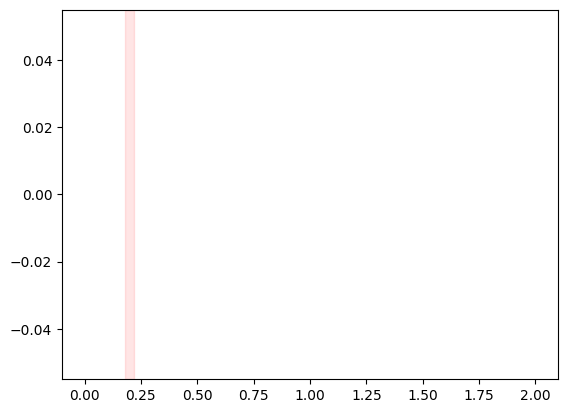

In [63]:
""" Comparaison des moments théoriques et empiriques avec le réseau de neurones """

inputs_tensor, targets_tensor = generate_data(num_inputs, 1, timeSample, nbrAutoCov=nbrAutoCov, nbrMoments=nbrMoments)

plt.hist(net(inputs_tensor).detach().numpy()[:,0], bins = 50,range = (0,2))
plt.axvspan(0.9*a1, 1.1*a1, color='red', alpha=0.1)
plt.show()
